In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# kernel svm
class SVM:
    def __init__(self):
        self._x = self._y = None
        self_alpha = self_b = self._kernel = None
    
    def _rbf(self, x, y, gamma):
        return np.exp(-gamma * np.sum((x[..., None, :] - y)**2, axis=2))
    
    def _poly(self, x, y, p=4):
        return (x.dot(y.T) + 1 )**p
    
    def predict(self, x):
        x = np.atleast_2d(x).astype(np.float32)         # convet x to 2d array
        k_mat = self._kernel(self._x, x)
        y_pred = (self._y * self._alpha).dot(k_mat) + self._b
        return np.sign(y_pred).astype(np.float32)
        
    def fit(self, x, y, kernel='rbf', p=None, gamma=None, c=1, lr=0.001, batch_size=128, epoch=1000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        if kernel == "poly":
            p = 4 if p is None else p
            self._kernel = lambda x_, y_: self._poly(x_, y_, p)
        elif kernel == "rbf":
            gamma = 1 / x.shape[1] if gamma is None else gamma
            self._kernel = lambda x_, y_: self._rbf(x_, y_, gamma)
        else:
            raise NotImplementedError("Kernel '{}' has not defined".format(kernel))
        self._alpha = np.zeros(len(x))
        self._b = 0
        self._x = x
        self._y = y
        k_mat = self._kernel(x, x)
        k_mat_diag = np.diag(k_mat)
        for _ in range(epoch):
            indices = np.random.choice(len(y), batch_size)
            x_batch, y_batch, k_batch = self._x[indices], y[indices], k_mat[indices]
            self._alpha -= lr * (np.sum(self._alpha* y * k_mat, axis=1) + self._alpha * k_mat_diag) * 0.5
            err = 1 - y_batch * (k_batch.dot(self._alpha * self._y) + self._b)
            mask = err > 0
            n = len(y_batch[mask])
            if n == 0:
                continue
            else:
                delta = - c * lr * y_batch[mask]
                self._alpha -= y * np.sum(delta[:, None] * k_batch[mask], axis=0)
                self._b -= np.sum(delta)
            
            if _ % (epoch/10) == 0:
                print("{}/{} --> error:{}".format(_, epoch, n))
        y_pred = self.predict(x)
        print("train accuracy:{}".format(np.mean((y_pred == y).astype(np.float32))))
        return y_pred

In [3]:
digits = datasets.load_digits()
data, label = digits.data, digits.target
print(data.shape, label.shape)

(1797, 64) (1797,)


In [4]:
label_1, label_2 = label == 1, label == 2
data_1, data_2 = data[label_1], data[label_2]
train_data = np.concatenate((data_1, data_2), axis=0)
label_1, label_2 = np.array([1]*data_1.shape[0]), np.array([-1]*data_2.shape[0])
train_label = np.concatenate((label_1, label_2), axis=0)
print(train_data.shape, train_label.shape)

(359, 64) (359,)


In [5]:
svm = SVM()
y_pred = svm.fit(train_data, train_label, epoch=10000)

0/10000 --> error:128
1000/10000 --> error:128
2000/10000 --> error:121
3000/10000 --> error:111
4000/10000 --> error:81
5000/10000 --> error:56
train accuracy:1.0


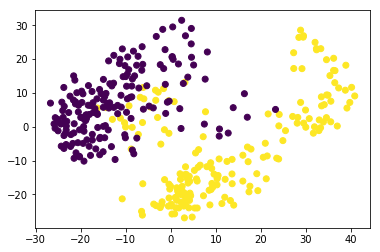

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(train_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_label)

In [7]:
svm = SVM()
y_pred = svm.fit(reduced_data, train_label, epoch=10000)

0/10000 --> error:128
1000/10000 --> error:69
2000/10000 --> error:68
3000/10000 --> error:22
4000/10000 --> error:63
5000/10000 --> error:14
6000/10000 --> error:6
7000/10000 --> error:4
8000/10000 --> error:6
9000/10000 --> error:10
train accuracy:0.961002767086029


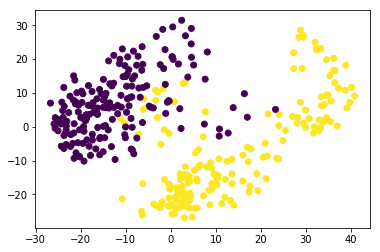

In [8]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred)

In [9]:
x_grid = np.arange(-30, 40, 1)
y_grid = np.arange(-30, 35, 1)
coor = []
for x in x_grid:
    for y in y_grid:
        coor.append([x, y])
mesh = np.array(coor)

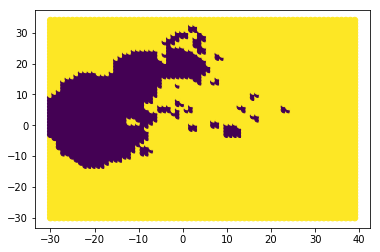

In [10]:
mesh_label = svm.predict(mesh)
plt.scatter(mesh[:, 0], mesh[:, 1], c=mesh_label)